# Problem Set 3
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 17-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the corresponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Holmin, Sebastian**
- Personnummer: **970602-3679**
  <br/>
  (civic registration number)

## Problems
The 10 basic points of this problem set are distributed over four problems:
1. Assigning probabilities for a hundred-sided die (2 basic points)
2. Chi-squared hypothesis testing (2 basic points)
3. Gaussian process regression (3 basic points)
4. Neural network classification (3 basic points)

Each of them will be presented in a separate jupyter notebook.

## Problem 4: Neural network classification
### (3 basic points)
<!-- Author: -->  
Christian Forssén, Chalmers, and
Morten Hjorth-Jensen, University of Oslo and Michigan State University

The task is to implement a fully-connected neural network with a single hidden layer (50 nodes) and a 10-node output layer that works as a multi-label classifier. Specifically, the neural network should be used to classify images of hand written digits using a reduced version of the MNIST database.
* In particular, you need to implement the forward pass.
* A working code for back-propagation is included, but you will have to combine the different ingredients and perform the training.
* Finally, you should study some properties of the final network and some details of the training.

The specific tasks are described at the various stages of the neural network implementation which is outlined below.

## Developing a code for doing neural networks with back propagation

One can identify a set of key steps when using neural networks to solve supervised learning problems:  
  
1. Collect and pre-process data  
1. Define model and architecture  
1. Choose cost function and optimizer  
1. Train the model  
1. Adjust hyperparameters (if necessary, network architecture)
1. Evaluate model performance on test data  

### Collect and pre-process data

Here we will be using the MNIST dataset, which is readily available through the **scikit-learn**
package. You may also find it for example [here](http://yann.lecun.com/exdb/mnist/).  
The *MNIST* (Modified National Institute of Standards and Technology) database is a large database
of handwritten digits that is commonly used for training various image processing systems.  
The MNIST dataset consists of 70 000 images of size $28\times 28$ pixels, each labeled from 0 to 9.  
The scikit-learn dataset we will use consists of a selection of 1797 images of size $8\times 8$ collected and processed from this database.  

Each input image is a 2D matrix, but we will flatten the image
(i.e. "unravel" the 2D matrix into a 1D array) to turn the data into a
design/feature matrix. This means we lose all spatial information in the
image, such as locality and translational invariance. More complicated
architectures such as Convolutional Neural Networks can take advantage
of such information, and are most commonly applied when analyzing
images.

inputs: (n_data, pixel_width, pixel_height) = (1797, 8, 8)
                       with labels (n_data) = (1797,)

flattened input, X: (n_inputs, n_features)  = (1797, 64)


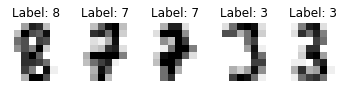

In [96]:
# import 
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

# ensure the same random numbers appear every time
np.random.seed(0)

# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print(f"inputs: (n_data, pixel_width, pixel_height) = {inputs.shape}")
print(f"                       with labels (n_data) = {labels.shape}")


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print(f"\nflattened input, X: (n_inputs, n_features)  = {inputs.shape}")


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {digits.target[random_indices[i]]:1}")

## Train and test datasets

Performing analysis before partitioning the dataset is a major error, that can lead to incorrect conclusions.  

We will reserve $70 \%$ of our dataset for training and $30 \%$ for testing.  

It is important that the train and test datasets are drawn randomly from our dataset, to ensure
no bias in the sampling.  
Say you are taking measurements of weather data to predict the weather in the coming 5 days.
You don't want to train your model on measurements taken from the hours 00.00 to 12.00, and then test it on data
collected from 12.00 to 24.00.

In [98]:
### from sklearn.model_selection import train_test_split

# ensure the same random numbers appear every time
np.random.seed(0)

train_size = 0.7
test_size = 1 - train_size
#Here I added indices so I can see how the data was split for task 3
X_train, X_test, Y_train, Y_test, indTrain, indTest = train_test_split(inputs, labels,range(n_inputs), train_size=train_size,
                                                    test_size=test_size)

print(f"Number of training images: {len(X_train):4}")
print(f"Number of test images:     {len(X_test):4}")

Number of training images: 1257
Number of test images:      540


## Define model and architecture

Our simple feed-forward neural network will consist of an *input* layer, a single *hidden* layer and an *output* layer. The activation $y$ of each neuron is a weighted sum of inputs, passed through an activation function. In case of the simple perceptron model we have 

$$ z = \sum_{i=1}^n w_i a_i + b,$$

$$ y = f(z) ,$$

where $f$ is the activation function, $a_i$ represents input from neuron $i$ in the preceding layer,
$w_i$ is the weight to input $i$ and $b$ is the bias.

The activation of the neurons in the input layer is just the features (e.g. a pixel value).  

The simplest activation function for a neuron is the *Heaviside* step function. Other typical choices for activation functions include the sigmoid function, hyperbolic tangent, and Rectified Linear Unit (ReLU).  
We will be using the sigmoid function $\sigma(z)$:  

$$ f(z) = \sigma(z) = \frac{1}{1 + e^{-z}} ,$$


## Layers

* Input 

Since each input image has 8x8 = 64 pixels or features, we have an input layer of 64 neurons.  

* Hidden layer

We will use 50 neurons in the hidden layer receiving input from the neurons in the input layer.  
Since each neuron in the hidden layer is connected to the 64 inputs we have 64x50 = 3200 weights to the hidden layer.  We also have 50 biases.

* Output

If we were building a binary classifier, it would be sufficient with a single neuron in the output layer,
which could output 0 or 1 according to the Heaviside function. This would be an example of a *hard* classifier, meaning it outputs the class of the input directly. However, if we are dealing with noisy data it is often beneficial to use a *soft* classifier, which outputs the probability of being in class 0 or 1.  

For a soft binary classifier, we could use a single neuron and interpret the output as either being the probability of being in class 0 or the probability of being in class 1. Alternatively we could use 2 neurons, and interpret each neuron as the probability of being in each class.  

Since we are doing multiclass classification, with 10 categories, it is natural to use 10 neurons in the output layer. We number the neurons $j = 0,1,...,9$. The activation of each output neuron $j$ will be according to the *softmax* function:  

$$ P(\text{class $j$} \mid \text{input $\hat{a}$}) = \frac{\exp{(\hat{a}^T \hat{w}_j)}}
{\sum_{c=0}^{9} \exp{(\hat{a}^T \hat{w}_c)}} ,$$  

i.e. each neuron $j$ outputs the probability of being in class $j$ given an input from the hidden layer $\hat{a}$, with $\hat{w}_j$ the weights of neuron $j$ to the inputs.  
The denominator is a normalization factor to ensure the outputs (probabilities) sum up to 1.  
The exponent is just the weighted sum of inputs as before:  

$$ z_j = \sum_{i=1}^n w_ {ij} a_i+b_j.$$  

Since each neuron in the output layer is connected to the 50 inputs from the hidden layer we have 50x10 = 500
weights to the output layer. We also have 10 biases.

## Weights and biases

Typically weights are initialized with small values distributed around zero, drawn from a uniform
or normal distribution. Setting all weights to zero means all neurons give the same output, making the network useless.  

Adding a bias value to the weighted sum of inputs allows the neural network to represent a greater range
of values. Without it, any input with the value 0 will be mapped to zero (before being passed through the activation).  

$$ z_j = \sum_{i=1}^n w_ {ij} a_i + b_j.$$  

The bias weights $\hat{b}$ are often initialized to zero, but a small value like $0.01$ ensures all neurons have some output which can be backpropagated in the first training cycle.

In [99]:
# initializing our neural network

n_inputs, n_features = X_train.shape
n_hidden_neurons = 50
n_categories = 10

# we make the weights normally distributed using numpy.random.randn


# ensure the same random numbers appear every time
np.random.seed(0)

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01


## Feed-forward pass

Denote $F$ the number of features (inputs), $H$ the number of hidden neurons and $C$ the number of categories.  
For each input image we calculate a weighted sum of input features (pixel values) to each neuron $j$ in the hidden layer $h$:  

$$ z_{j}^{l} = \sum_{i=1}^{F} w_{ij}^{h} x_i + b_{j}^{h},$$

this is then passed through our activation function  

$$ a_{j}^{h} = f(z_{j}^{h}) .$$  

We calculate a weighted sum of inputs (activations in the hidden layer) to each neuron $j$ in the output layer:  

$$ z_{j}^{L} = \sum_{i=1}^{H} w_{ij}^{L} a_{i}^{h} + b_{j}^{L}.$$  

Finally we calculate the output of neuron $j$ in the output layer using the softmax function:  

$$ y_{j}^{L} = \frac{\exp{(z_j^{L})}}
{\sum_{c=0}^{C-1} \exp{(z_c^{L})}} .$$  

### Matrix multiplications

Since our data has the dimensions $X = (n_\mathrm{data}, n_\mathrm{features})$ and our weights [biases] to the hidden layer have the dimensions  
$W^\mathrm{h} = (n_\mathrm{features}, n_\mathrm{hidden})$ [$b^\mathrm{h} = (n_\mathrm{hidden},)$],
we can easily feed the network all our training data in one go by using matrix products.

The final output should be the probabilities $\hat{y}^L$ of dimension $(n_\mathrm{data}, n_\mathrm{categories})$.

Moreover, in order to implement the backpropagation step we also need the output signals ($\hat{a}^h$) from the hidden layer.

**Note:** that weights and biases are global variables in this implementation (not good coding practice!)

### Task 1: Implement the feed-forward pass
* Implement the feed-forward pass by modifying the code below.
* Test the implementation by feeding the input data and making predictions for all class labels (note that the network parameters have not been optimized so the predictions will be rubbish).

In [100]:
# setup the feed-forward pass, subscript h = hidden layer
#
# Note that weights and biases are global variables in this implementation
# (not good coding practice!)
def sigmoid(z):
    return 1/(1+np.exp(-z))

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z),axis=1).reshape(-1,1)

def feed_forward(X):
    """
    Feed-forward pass.
    Uses hidden_weights, hidden_bias, output_weights, output_bias
    
    Args:
        X (array[float]): input to the neural network

    Returns:
        a_h (array[float]): activation in the hidden layer
        probabilities (array[float]): probabilities of each category
    """

    a_h = sigmoid(X.dot(hidden_weights)+hidden_bias)
    z_L=a_h.dot(output_weights)+output_bias
    probabilities = softmax(z_L)
    
    return a_h, probabilities

# prediction of class label
def predict(X):
    """
    Return a prediction by finding the class with the highest likelihood.

    Args:
        X (array[float]): input to the neural network

    Returns:
        label (integer): index of the category with the highest probability
    """

    a_h, probabilities = feed_forward(X)
    
    class_label = np.argmax(probabilities,axis=1)
    return class_label

## Choose cost function and optimizer

To measure how well our neural network is doing we need to introduce a cost function.  
We will call the function that gives the error of a single sample output the *loss* function, and the function
that gives the total error of our network across all samples the *cost* function.
A typical choice for multiclass classification is the *cross-entropy* loss.  

In *multiclass* classification it is common to treat each integer label as a so called *one-hot* vector:  

$$ t = 5 \quad \rightarrow \quad \hat{y} = (0, 0, 0, 0, 0, 1, 0, 0, 0, 0) ,$$  

$$ t = 1 \quad \rightarrow \quad \hat{y} = (0, 1, 0, 0, 0, 0, 0, 0, 0, 0) ,$$  

i.e. a binary bit string of length $C$, where $C = 10$ is the number of classes.  

Let $t_{ic}$ denote the $c$-th component of the $i$-th one-hot vector.  
We define the cost function $\mathcal{C}$ as a sum over the cross-entropy loss for each point $\hat{x}_i$ in the dataset.

In the one-hot representation only one of the terms in the loss function is non-zero, namely the
probability of the correct category $c'$  
(i.e. the category $c'$ such that $t_{ic'} = 1$). This means that the cross entropy loss only punishes you for how wrong
you got the correct label. The probability of category $c$ is given by the softmax function. The vector $\hat{\theta}$ represents the parameters of our network, i.e. all the weights and biases.  

In [101]:
# to categorical turns our integer vector into a onehot representation
# we implement it in in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

## Optimizing the cost function

The network is trained by finding the weights and biases that minimize the cost function. One of the most widely used classes of methods is *gradient descent* and its generalizations. The idea behind gradient descent
is simply to adjust the weights in the direction where the gradient of the cost function is large and negative. This ensures we flow toward a *local* minimum of the cost function.  
Each parameter $\theta$ is iteratively adjusted according to the rule  

$$ \theta_{i+1} = \theta_i - \eta \nabla \mathcal{C}(\theta_i) ,$$

where $\eta$ is known as the *learning rate*, which controls how big a step we take towards the minimum.  
This update can be repeated for any number of iterations, or until we are satisfied with the result.  

#### Extra feature (not necessarily used in this implementation)
A simple and effective improvement is a variant called *Batch Gradient Descent*.  
Instead of calculating the gradient on the whole dataset, we calculate an approximation of the gradient
on a subset of the data called a *minibatch*.  
If there are $N$ data points and we have a minibatch size of $M$, the total number of batches
is $N/M$.  
We denote each minibatch $B_k$, with $k = 1, 2,...,N/M$. The gradient then becomes:  

$$ \nabla \mathcal{C}(\theta) = \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}_i(\theta) \quad \rightarrow \quad
\frac{1}{M} \sum_{i \in B_k} \nabla \mathcal{L}_i(\theta) ,$$

i.e. instead of averaging the loss over the entire dataset, we average over a minibatch.  

This has two important benefits:  
1. Introducing stochasticity decreases the chance that the algorithm becomes stuck in a local minima.  

2. It significantly speeds up the calculation, since we do not have to use the entire dataset to calculate the gradient.  

## Regularization

It is common to add an extra term to the cost function, proportional
to the size of the weights.  This is equivalent to constraining the
size of the weights, so that they do not grow out of control.
Constraining the size of the weights means that the weights cannot
grow arbitrarily large to fit the training data, and in this way
reduces *overfitting*.

We will measure the size of the weights using the so called *L2-norm*, meaning our cost function becomes:  

$$  \mathcal{C}(\theta) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}_i(\theta) \quad \rightarrow \quad
\frac{1}{N} \sum_{i=1}^N  \mathcal{L}_i(\theta) + \alpha \frac{1}{2}  \lvert \lvert \hat{w} \rvert \rvert_2^2 
= \frac{1}{N} \sum_{i=1}^N  \mathcal{L}(\theta) + \alpha \frac{1}{2} \sum_{ij} w_{ij}^2,$$  

i.e. we sum up all the weights squared. The factor $\alpha$ is known as the weight decay and it is a regularization parameter.

## Back-propagation
In order to train the model, we need to calculate the derivative of
the cost function with respect to every bias and weight in the
network.  In total our network has $(64 + 1)\times 50=3250$ parameters in
the hidden layer and $(50 + 1)\times 10=510$ parameters in the output
layer (the $+1$ is for the bias), and the gradient must be calculated for
every parameter.  We use the *backpropagation* algorithm, which is a clever use of the chain rule that allows us to
calculate the gradient efficently. 

### Matrix  multiplication

To more efficently train our network these equations are implemented using matrix operations.  
The error in the output layer is calculated simply as, with $\hat{t}$ being our targets,  

$$ \delta_L = \hat{t} - \hat{y} \qquad (n_\mathrm{data}, n_\mathrm{categories}) .$$  

The gradient for the output weights is calculated as  

$$ \nabla W_{L} = \hat{a}^T \delta_L  \qquad (n_\mathrm{hidden}, n_\mathrm{categories}) ,$$

where $\hat{a} = (n_\mathrm{data}, n_\mathrm{hidden})$. This simply means that we are summing up the gradients for each input.  
Since we are going backwards we have to transpose the activation matrix.  

The gradient with respect to the output bias is then  

$$ \nabla \hat{b}_{L} = \sum_{i=1}^{n_\mathrm{data}} \delta_L \qquad (n_\mathrm{categories}) .$$  

The error in the hidden layer is  

$$ \Delta_h = \delta_L W_{L}^T \circ f'(z_{h}) = \delta_L W_{L}^T \circ a_{h} \circ (1 - a_{h}) \qquad (n_\mathrm{data}, n_\mathrm{hidden}) ,$$  

where $f'(a_{h})$ is the derivative of the activation in the hidden layer. The matrix products mean
that we are summing up the products for each neuron in the output layer. The symbol $\circ$ denotes
the *Hadamard product*, meaning element-wise multiplication.  

This again gives us the gradients in the hidden layer:  

$$ \nabla W_{h} = X^T \delta_h \qquad (n_\mathrm{features}, n_\mathrm{hidden}) ,$$  

$$ \nabla b_{h} = \sum_{i=1}^{n_\mathrm{data}} \delta_h \qquad (n_\mathrm{hidden}) .$$

**Note: The back-propagation is implemented below.**

In [102]:
from sklearn.metrics import accuracy_score

def backpropagation(X, Y):
    a_h, probabilities = feed_forward(X)
    
    # error in the output layer
    error_output = probabilities - Y
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

### Task 2: Train the network
* Implement the training of the network by modifying the code below.
* Use a fixed learning rate $\eta=0.001$ and a weight decay $\alpha=0.1$, but feel free to explore other parameters.
* Make 1000 iterations, where you employ the entire training set in each iteration.
* What is the accuracy on the training set before and after the training?

The accuracy is as you would expect just the number of images correctly labeled divided by the total number of images. A perfect classifier will have an accuracy score of $1$.  

$$ \text{Accuracy} = \frac{\sum_{i=1}^n I(\hat{y}_i = y_i)}{n} ,$$  

where $I$ is the indicator function, $1$ if $\hat{y}_i = y_i$ and $0$ otherwise.

In [103]:
# accuracy score from scikit library
print(f"Accuracy on training data: {accuracy_score(predict(X_train), Y_train):.3f}")
print(f"Accuracy on test data: {accuracy_score(predict(X_test), Y_test):.3f}")

Accuracy on training data: 0.046
Accuracy on test data: 0.046


In [104]:
eta = 0.001
alpha = 0.1
iters = 1000

# Arrays for storing weights during training
mdWh = np.array([])
vdWh = np.array([])
for i in range(iters):
    # calculate gradients
    dWo, dBo, dWh, dBh = backpropagation(X_train, Y_train_onehot)
    # Add the regularization term gradients to the weights

    dWh += alpha*hidden_weights
    dWo += alpha*output_weights
    mdWh = np.append(mdWh,np.mean(np.abs(dWh)))
    vdWh = np.append(vdWh,np.var(np.abs(dWh)))
    # Finally, update weights and biases

    output_weights -= eta*dWo
    output_bias -= eta*dBo
    hidden_weights -= eta*dWh
    hidden_bias -= eta*dBh

### Task 3: Evaluate model performance on test data
To measure the performance of our network we evaluate how well it does it data it has never seen before, i.e. the test data.  
We measure the performance of the network using the *accuracy* score.  
* What is the accuracy score on the test data?
* Take a look at (some of) the images that were incorrectly classified.

Accuracy on test data: 0.926

Predicted values  [3 8 8 9]


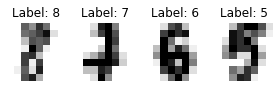

In [106]:
print(f"Accuracy on test data: {accuracy_score(predict(X_test), Y_test):.3f}")

pred = predict(X_test)
wrong = np.array(np.where(pred-Y_test != 0)[0][0:4]) #Test if predictions are correct
wrong_indices = [indTest[wrong[0]],indTest[wrong[1]],indTest[wrong[2]],indTest[wrong[3]]] #Get the corresponding indices 


print('\nPredicted values ',pred[wrong])
for i, image in enumerate(digits.images[wrong_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {digits.target[wrong_indices[i]]:1}")

### Task 4: Study the neural network before, after and during training
* Plot the mean of the absolute values of gradients with respect to the weights in the hidden layer, and the variance of those gradients during training. Do you see the convergence?

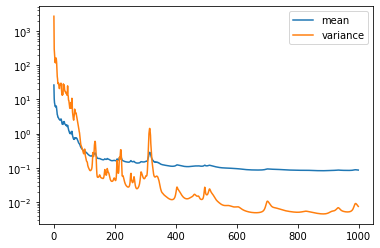

In [93]:
plt.plot(mdWh)
plt.plot(vdWh)
plt.yscale('log')
plt.legend(['mean','variance'])